# Saroma sea ice school 2026
# General introduction to climate data analysis

In this tutorial we will:
> Load `CMIP6` climate data directly into `Python` through `Pangeo` <br />
> Use `xarray` and `pandas` to manipulate the data (selection, averaging, resampling, interpolation...) <br />
> Plot fancy maps using `cartopy` and with custom colorbars <br />
> Learn that you can easily download `Copernicus` data through their `Python` API <br />

First thing to do in `Python`: load the libraries that will be useful for our project.

In [1]:
# when you use external functions in a functions.py file
# using the option below automatically applies the changes made to functions.py
%load_ext autoreload
%autoreload 2

In [41]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.path as mpath
import seaborn as sns
import warnings
import cartopy
import cartopy.crs as ccrs
import hvplot
import hvplot.xarray
import fsspec
import pymannkendall as mk
import scipy
warnings.filterwarnings("ignore")
#plt.rcParams.update({'font.size': 12})
#mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = (12, 7)
pd.options.plotting.backend = 'hvplot'

# custom library of useful homemade functions
import sys
sys.path.insert(1, '../data')
from functions import *

<h1 style="text-align: center;">SECTION 1: load climate data from Pangeo</h1>

`Pangeo` is a community platform for Big Data geoscience (https://pangeo.io/) which, among other things, provides access to data catalogs such as `CMIP6` output. Using the associated python libraries is a powerful tool for the analysis of climate data without ever having to download and store them.

The workflow I recommend for this use is:
1. Assess the existence of the `CMIP6` data you are interested in through the `ESGF` platform (https://esgf-node.ipsl.upmc.fr/search/cmip6-ipsl/). I recommend using the `CMIP6` data catalog (https://clipc-services.ceda.ac.uk//dreq/mipVars.html) for better understanding of the variable names and contents
2. Once you have identified the data sets you want on `ESGF`, apply the associated filters in the scripts below when searching the `Pangeo` catalog

#### Connect to the pangeo storage catalog using `intake`

In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

#### Search through the catalog
In this example, we want to look at monthly ('Amon') surface temperature ('tas') in one CMIP6 model ('NorESM2-MM'), for the 'historical' experiment and the variant 'r1i1p1f1'. We do a search through the pangeo catalog using the appropriate keys.

In [4]:
cat = col.search(variable_id=['tas'], 
                 member_id=['r1i1p1f1'],
                 source_id=['NorESM2-MM'],
                 experiment_id=['historical'],
                 table_id=['Amon'])

NB: you can do a search for multiple values in each field, e.g. you can try loading precipitation as well by replacing, ['tas'] with ['tas','pr']. This applies for any field in the search

#### Make a dictionary from the search results

In [5]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


#### List the available keys in the dictionary to make sure we got what we wanted

In [6]:
dataset_list = list(dset_dict.keys())
dataset_list

['CMIP.NCC.NorESM2-MM.historical.Amon.gn']

#### Select the data set
In this case there is only one data set in the search (hence the dataset_list[0] below), but you can load several data sets at once e.g. if you also want precipitation, variable_id=['tas'] above becomes variable_id=['tas','pr'] and you would have to select each separately (dataset_list[0] and dataset_list[1]).

Also, here we use the .chunk() method to chunk the data set into smaller pieces to make loading faster. For this tutorial you don't have to care but if you use `xarray` in the future it can be convenient to know more about .chunk() (and `dask`).

In [7]:
dset = dset_dict[dataset_list[0]].chunk(chunks={'time':20,'lat':10,'lon':10})
dset

<xarray.Dataset>
Dimensions:         (lat: 192, bnds: 2, lon: 288, member_id: 1,
                     dcpp_init_year: 1, time: 1980)
Coordinates:
    height          float64 ...
  * lat             (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(10, 2), meta=np.ndarray>
  * lon             (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(10, 2), meta=np.ndarray>
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds       (time, bnds) object dask.array<chunksize=(20, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: bnds
Data variables:
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 20, 10, 10), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Hybrid-restart from year 1200-01-01 of ...
    branch_time:                      0.0
    branch_time_in_child:             0.0
    branch_time_in_parent:            438000.0
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCC/NorESM2-MM/hi...
    intake_esm_attrs:version:         20191108
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCC.NorESM2-MM.historical.Amon.gn

In [8]:
dset = dset.compute() # remove the chunks for ease of use later as this data is not too big

If you prefer to use a dataset that you have locally for what comes next, you can equivalently load the data into `xarray` with xr.open_dataset() and start from here (see Section Copernicus for an example using xr.open_dataset()).

---
---

<h1 style="text-align: center;">SECTION 2: select, resample, groupby...</h1>

The data previously loaded is "stored" in an `xarray` dataset. This is probably the most convenient way to deal with large data sets in `Python` as the data is not fully loaded in cache as `numpy`-based libraries would do. As a result, all the manipulations on the data (averaging, resampling...) are very fast. If you haven't yet, I highly recommend you make the switch to `xarray` if you manupilate `netcdf` files regularly. It could change your life (no exaggeration).

You don't have to take my word for it, just try it yourself with the following examples. If you are curious, you can convert the `xarray` dataset used here into a `numpy` and try to make the same manipulations so you can compare computing times.

Now let's play around with the data, select specific areas, time periods, aggregate data 

### The .sel() method of `xarray`

This method allows you to select values or a range of values along any dimension of the data set. Here is an example where we select over time and latitutde/longitude.

In [9]:
# select only a few years using the .sel() method
dset = dset.sel(time=slice('1990','2014')).squeeze()

# select a lat/lon region in the world - here Japan area
# feel free to change these values to whatever region you'd like to study
tas_subregion = dset.sel(lat=slice(31,46),lon=slice(128,148))

Let's plot the result of the selection by looking at the first time in the data set. If you know what is the value of the time step you want you can use the .sel() method (e.g. .sel(time='1990-01')). If you do not know how it is called but you know it is the n$^{\textrm{th}}$ step, you can use .isel() as .isel(time=n-1) as we are doing here.

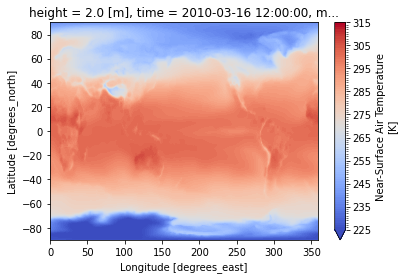

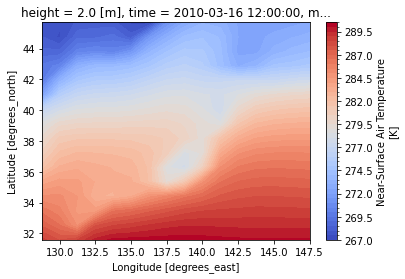

In [10]:
# plot the month of march 2010 as a filled contour

# of the whole domain
dset.tas.sel(time='2010-03').squeeze().plot.contourf(levels=np.linspace(225,315,91),cmap='coolwarm')
plt.show()

# of the selected region
tas_subregion.tas.sel(time='2010-03').squeeze().plot.contourf(levels=50,cmap='coolwarm')
plt.show()

### The mean(), resample() and groupby() methods of `xarray`

The .mean() method allows you to average your data set over any dimension/group of dimensions. You can use, equivalently, the .min(), .max(), .median(), .quantile() methods for min, max, median or quantile computation. In this example we will take the spatial average of temperature over the selected subregion.
NB: spatial averages need to account for the fact that the latitude-km relationship changes with latitude, hence the weighted mean instead of a simple mean.

The .resample() methods allows you to resample the data at a certain frequency. Resampling needs to be followed by one of the methods above (mean, min, max...). For example, here we want to compute the yearly maximum temperature, so we .resample() by year and take the .max().

The .groupby() method is useful to group data by a given criterion. In the example below we will apply it to obtain the min and max values of the regional mean for each calendar month over the period (e.g. min and max January values for the period).

In [11]:
# spatial weighted mean
weights = np.cos(np.deg2rad(tas_subregion.lat))
tas_subregion_avg = tas_subregion.weighted(weights).mean(dim=('lat','lon'))

# groupby() to get the mean/min/max for each calendar month over the period
tas_subregion_avg_mn = tas_subregion_avg.groupby(tas_subregion_avg.time.dt.month).mean()
tas_subregion_avg_min = tas_subregion_avg.groupby(tas_subregion_avg.time.dt.month).min()
tas_subregion_avg_max = tas_subregion_avg.groupby(tas_subregion_avg.time.dt.month).max()

# resample() to aggregate data from monthly to annual
# and apply the .max() method to get the annual maximum
tas_subregion_yearly_max = tas_subregion.resample(time='1Y').max()

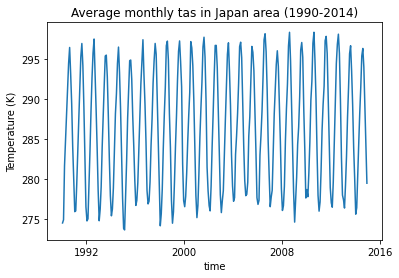

In [12]:
tas_subregion_avg.tas.plot()
plt.title('Average monthly tas in Japan area (1990-2014)')
plt.ylabel('Temperature (K)')
plt.show()

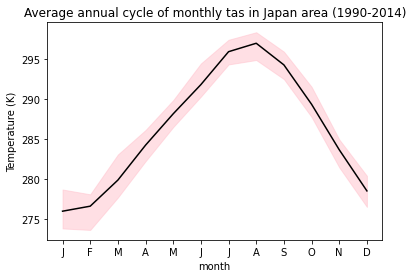

In [13]:
tas_subregion_avg_mn.tas.plot(color='black')

plt.fill_between(tas_subregion_avg_min.month,
                 tas_subregion_avg_min.tas,
                 tas_subregion_avg_max.tas,
                 color='pink',
                 alpha=0.5,
                 zorder=0)
plt.xticks(np.arange(1,13),['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.title('Average annual cycle of monthly tas in Japan area (1990-2014)')
plt.ylabel('Temperature (K)')
plt.show()

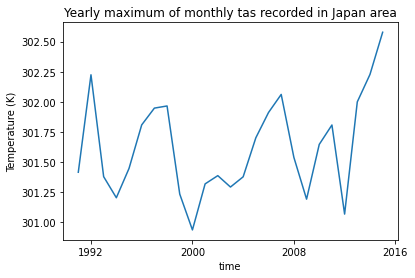

In [14]:
tas_subregion_yearly_max.tas.max(dim=('lat','lon')).plot()
plt.title('Yearly maximum of monthly tas recorded in Japan area')
plt.ylabel('Temperature (K)')
#plt.xticks(np.arange(0,25,5),np.arange(1990,2015,5))
plt.show()

#### Give it a try yourself
Think of a manipulation you would need to do in real life and implement it and then plot the result.

---
---

<h1 style="text-align: center;">SECTION 3: plot nice maps!</h1>



In this section, we will use `cartopy` to plot geospatial data, and a homemade function to create custom colorbars.

Let's say we want to plot 
- the average monthly surface air temperature
- for NH summer months only
- for the years 2000 to 2010 only

#### Write the appropriate sel and mean methods to do that below

In [15]:
tas_jja = dset.sel(time=dset['time.season']=='JJA')

# select 2000 to 2010 only
tas_jja_2000_2010 = tas_jja.sel(time=slice('2000','2010'))

# average along time dimension
tas_mean_jja_2000_2010 = tas_jja_2000_2010.tas.mean(dim='time').squeeze()

Now we will make map plots of this data. Available colormaps in `matplotlib` can quickly become quite limited. Below is a homemade function to create a custom colorbar of your choice (see functions.py for how it works - kudos to Theodore Kadir for creating it).
The first argument is a list of rgb colors, N is the number of intervals you want, and if you want the colorbar to go in reverse direction, set reverse='r'

In [16]:
cmap_GoldenTheo = build_cmap(colors=[(5/256, 41/256, 132/256),(175/256, 186/256, 219/256),
                              (249/256, 240/256, 216/256),(237/256, 204/256, 142/256),
                              (126/256, 90/256, 79/256)], 
                             N=25,
                             reverse='no')

We will use `cartopy` to plot our maps, using 3 different projections

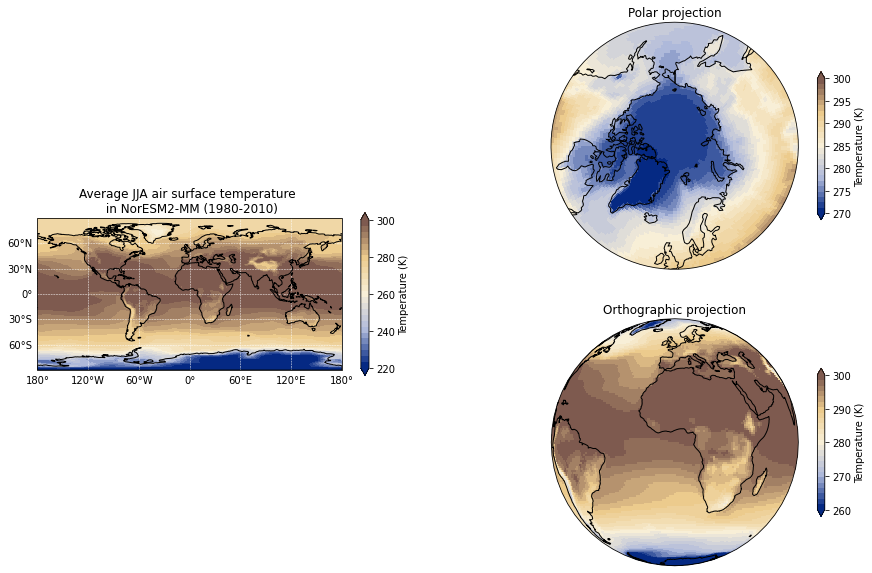

In [17]:
# create figure and define its size
fig = plt.figure(figsize=(15,10))

# use the PlateCarree projection
ax1 = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax1.set_extent([-180,180,-90,90], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(1,1,1,0))
ax1.set_title('Average JJA air surface temperature \n in NorESM2-MM (1980-2010)')
gl = ax1.gridlines(crs=ccrs.PlateCarree(),
                   draw_labels=True,
                   linewidth=0.5,
                   color='white',
                   linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

c1 = ax1.pcolormesh(tas_mean_jja_2000_2010.lon,
                    tas_mean_jja_2000_2010.lat,
                    tas_mean_jja_2000_2010,
                    cmap = cmap_GoldenTheo,
                    vmin = 220,
                    vmax = 300)

plt.colorbar(c1, shrink=0.3, label='Temperature (K)', extend='both')

# use a polar projection
ax2 = plt.subplot(2,2,2,projection=ccrs.NorthPolarStereo())
ax2.set_extent([-180,180,50,90], ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(1,1,1,0))
ax2.set_title('Polar projection')
theta = np.linspace(0, 2*np.pi, 100)                                                                                                                                                                       
center, radius = [0.5, 0.5], 0.5                                                                                                                                                                           
verts = np.vstack([np.sin(theta), np.cos(theta)]).T                                                                                                                                                        
circle = mpath.Path(verts * radius + center)                                                                                                                                                               
ax2.set_boundary(circle, transform=ax2.transAxes) 

c2 = ax2.pcolormesh(tas_mean_jja_2000_2010.lon,
                    tas_mean_jja_2000_2010.lat,
                    tas_mean_jja_2000_2010,
                    cmap = cmap_GoldenTheo,
                    vmin = 270,
                    vmax = 300,
                    transform=ccrs.PlateCarree())

plt.colorbar(c2, shrink=0.6, label='Temperature (K)', extend='both')

# use an orthographic projection
ax3 = plt.subplot(2,2,4,projection=ccrs.Orthographic())
ax3.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(1,1,1,0))
ax3.set_title('Orthographic projection')

c3 = ax3.pcolormesh(tas_mean_jja_2000_2010.lon,
                    tas_mean_jja_2000_2010.lat,
                    tas_mean_jja_2000_2010,
                    cmap = cmap_GoldenTheo,
                    vmin = 260,
                    vmax = 300,
                    transform=ccrs.PlateCarree())

plt.colorbar(c3, shrink=0.6, label='Temperature (K)', extend='both')


plt.show()

---
---

<h1 style="text-align: center;">SECTION 4: interpolate and compare to observations</h1>

In this section, we will compare the `CMIP6` simulated temperature to reanalysis data extracted in Saroma from the `ERA5` reanalysis. For the purpose of this exercise, we assume that ERA5 is like an observation data set. This will require spatial interpolation, which can be nicely done with `xarray`

First load the reanalysis data which is stored as a netcdf file, using `xarray` methods. This dataset is hourly surface temperature reanalysed in at the location of Saroma for 1940-2026. Downloaded from the climate data store (https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-timeseries?tab=overview).

After loading the data we transform it to keep only the relevant years and resample from hourly to monthly values, like in CMIP.

In [18]:
# temperature data in Saroma from ERA5
obs = xr.open_dataset('../data/t2m_Saroma_ERA5.nc')
obs['t2m'] = obs.t2m-273.15

In [19]:
# restrict data to the 1990--2014 period for readability
obs = obs.sel(valid_time=slice('1990','2014'))

# hourly data to monthly mean
obs_monthly = obs.resample({'valid_time':'M'}).mean()

Take only 2004-2014 in CMIP to match the observation period and interpolate to the nearest grid point to our measurement station. For the latter we use the .interp() method of `xarray`. There are several interpolation methods in `xarray`, go check them out they can be very useful. For example if you want to compare 2 maps that are on different grids and make a difference map, this can be done with `xarray` interp_like() method (see also next section).

In [20]:
temp_saroma_cmip = dset.sel(time=slice('1990','2014')).sel(lat=44.1,lon=143.8,method='nearest')-273.15

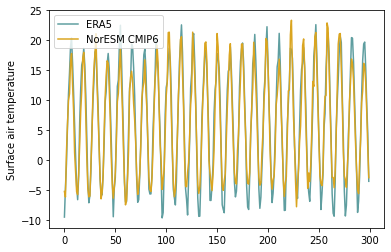

In [21]:
plt.plot(obs_monthly.t2m.values,
         label='ERA5',
         color='cadetblue')
plt.plot(temp_saroma_cmip.tas.values,
         label='NorESM CMIP6',
         color='goldenrod')
plt.ylabel('Surface air temperature')
plt.legend()
plt.show()

Now let's compare annual cycles like before

In [22]:
temp_saroma_cmip_monthly = temp_saroma_cmip.groupby(temp_saroma_cmip.time.dt.month).mean().squeeze()
temp_saroma_cmip_monthly_std = temp_saroma_cmip.groupby(temp_saroma_cmip.time.dt.month).std().squeeze()
obs_month = obs.groupby("valid_time.month").mean()

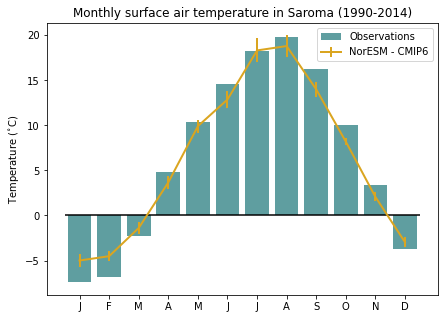

In [23]:
fig = plt.figure(figsize=(7,5))

plt.bar(obs_month.month,
        obs_month.t2m,
        color='cadetblue',
        label='Observations')

plt.errorbar(temp_saroma_cmip_monthly.month,
             temp_saroma_cmip_monthly.tas,
             yerr=temp_saroma_cmip_monthly_std.tas/2.0,
             linewidth=2,
             color='goldenrod',
             label='NorESM - CMIP6')

plt.hlines(0,0.5,12.5,color='k')
plt.xticks(temp_saroma_cmip_monthly.month,['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.ylabel('Temperature ($^{\circ}$C)')
plt.title('Monthly surface air temperature in Saroma (1990-2014)')
plt.legend()
plt.show()

---
---

<h1 style="text-align: center;">SECTION 5: Copernicus data</h1>

`Copernicus` data such as `ERA5` (climate reanalysis) or `CAMS` (air quality reanalysis) are available through the `Copernicus Climate Data Store` (https://cds.climate.copernicus.eu/).

A very interesting feature is that they provide the possibility to download the data via their web API, or through a `python` API, which you can run as a script from any server you might use for your work. For the latter option, they provide a tutorial here: https://cds.climate.copernicus.eu/api-how-to. This is a very convenient way to obtain the data. 

You can also load the data in the notebook without downloading locally, but it is quite slow. If you are already familiar with the `Climate Data Store` and have an API key you can give it a try with the code in the next cell.

We won't demonstrate this here because the setup requires that you create an account and generate an API key if you don't have one, but I strongly recommend you have a look on your own if you are using Copernicus data in the future.

For the purpose of the next exercise I already downloaded the monthly reanalysis of surface temperature from `ERA5` for the year 2010. As an illustration for the interpolation capabilities of `xarray`, we will make a difference map between `CMIP` and `ERA5` values, using the `interp_like()` method from `xarray`.

In [24]:
########################################################################
#### EXAMPLE TO BE TESTED ON YOUR MACHINE IF YOU HAVE A CDSAPI KEY #####
########################################################################
# import cdsapi

# c = cdsapi.Client()
# r = c.retrieve(
#     'reanalysis-era5-single-levels-monthly-means',
#     {
#         'product_type': 'monthly_averaged_reanalysis',
#         'variable': '2m_temperature',
#         'year': '2010',
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#         'time': '00:00',
#         'format': 'netcdf',
#     },
#     'tst.nc')

# ds = xr.open_dataset('tst.nc')
# ds.mean(dim='valid_time').t2m.plot()

Open ERA5 temperature data set and rename fields to CMIP convention for the interpolation

In [35]:
era5 = xr.open_dataset('../data/ERA5_monthly_temp_2010.nc')
era5 = era5.rename({'latitude':'lat','longitude':'lon','t2m':'tas','time':'Time'})

Select only 2010 in CMIP and drop useless dimension/attributes

In [36]:
dset_ = dset.sel(time='2010').squeeze()
dset_ = dset_.drop(['height','lat_bnds','lon_bnds','member_id','time_bnds'])

Now we have 2 data sets with the same variables/variable names, we can interpolate.

Warning: `CMIP` and `ERA5` use different time conventions. `CMIP` January is 01/16, `ERA5` January is 01/01. That's why I renamed the 'time' dimension in `ERA5`, to make it different so that interp_like() does not try to interpolate on this dimension. Otherwise you get NaN values. After interpolation I do the reverse operation and affect the CMIP time to ERA5 to ease manipulation in the continuation.

Note: For larger data sets, I usually prefer to use `cdo remapbil` in command line to regrid the data, I find this more efficient.

In [37]:
era5_interp = era5.interp_like(dset_)
era5_interp = era5_interp.rename({'Time':'time'})
era5_interp['time'] = dset_['time']

Now we have all the data on the same grid, we cam plot a difference map

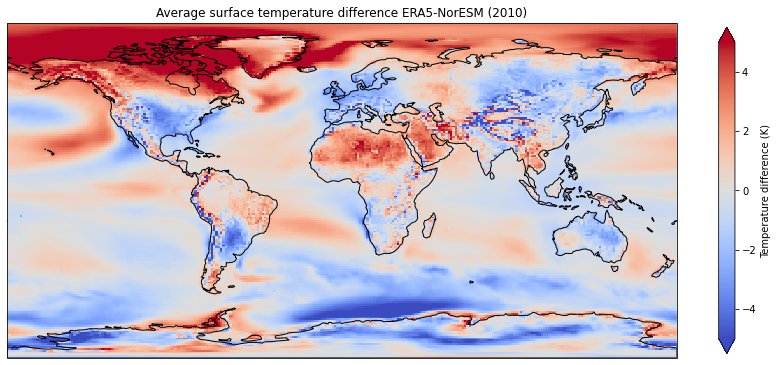

In [39]:
diff_era_cmip = (era5_interp - dset_).mean(dim='time')

fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax1.set_extent([-180,180,-90,90], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND,edgecolor='k',zorder=4,facecolor=(1,1,1,0))
ax1.set_title('Average surface temperature difference ERA5-NorESM (2010)')

c1 = ax1.pcolormesh(diff_era_cmip.lon,
                    diff_era_cmip.lat,
                    diff_era_cmip.tas,
                    cmap = 'coolwarm',
                    vmin = -5,
                    vmax = 5)

plt.colorbar(c1, shrink=0.6, label='Temperature difference (K)', extend='both')

plt.show()

---
--- 

<h1 style="text-align: center;">SECTION 6: Interactive plots with hvplot</h1>

`hvplot` is one the libraries you can use to plot `xarray` or `pandas` data in a more fancy way. In particular it is convenient for interactive visualisation, as illustrated in the example below.

Let's use our `ERA5` data set first and plot an interactive map where we can change the displayed time step. This is achieved using the groupby method in `hvplot`.

In [50]:
era5 = xr.open_dataset('../data/ERA5_monthly_temp_2010.nc')

In [51]:
era5.t2m.hvplot(x='longitude', y='latitude',groupby='time', width=500, cmap='coolwarm',clim=(250,305))

:DynamicMap   [time]
   :Image   [longitude,latitude]   (2 metre temperature)

---
---